In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [3]:
dataset = list(dataset)
shuffled_dataset = random.sample(dataset, len(dataset))
word_array = np.hstack(shuffled_dataset)
inputs = np.delete(word_array, -1)
labels = np.delete(word_array, 0)
# print(len(vocab))
# print(len(word_array))
# print(len(inputs))
# print(len(labels))
# print(2075676/3501)
# print(int(2075676/3501))

### Training Data: An array of articles
- Length: 579
- Shape:  (T,)
- Type:   int32

### Vocabulary:
- Length: 33278
- Type:   20 character unicode in little-endian form


In [4]:
# data loader

class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        
        self.dataset = list(dataset)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seqlen = 200
        
#         raise NotImplemented


    def __iter__(self):
        # concatenate your articles and build into batches
        
        shuffled_dataset = random.sample(self.dataset, len(self.dataset))
        word_array = np.hstack(shuffled_dataset)
        inputs = np.delete(word_array, -1)
        labels = np.delete(word_array, 0)
        batch_len = self.seqlen * self.batch_size
        nums_iter = int(len(inputs)/batch_len)+1
        for i in range(nums_iter-1):
            _input = inputs[i*batch_len:(i+1)*batch_len]
            _input = _input.reshape(self.seqlen,self.batch_size)
            _input = torch.tensor(_input,dtype=torch.int64)
            _label = labels[i*batch_len:(i+1)*batch_len]
            _label = _label.reshape(self.seqlen,self.batch_size)
            _label = torch.tensor(_label,dtype=torch.int64)
            yield((_input, _label))
        
#         raise NotImplemented

In [5]:
# loader = LanguageModelDataLoader(dataset=dataset, batch_size=64, shuffle=True)
# counter = 0
# for _input, _label in loader:
#     print(_input)
#     print(len(_input), len(_label))
#     counter += 1
#     print(counter)
#     break

In [6]:
class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, dropout=None):
        if not dropout:
            return x
        mask = torch.rand(1, x.size(1), x.size(2), requires_grad=False, device=DEVICE)
        mask = mask.bernoulli_(1 - dropout)/(1 - dropout)
        mask = mask.expand(x.size(0), -1, -1)
        return mask * x
        

In [7]:
# dropout = 0.8
# x = torch.randint(low=0, high=10, size=(10, 4, 256))
# drop = LockedDropout()
# x = drop(x, 0.5)
# print(x[0]>0)
# print(x[1]>0)

In [8]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size, embed_size, hidden_size, numlayers, bidirectional=False, 
                 dropoute = 0.1, dropouti=0.4, dropouth=0.25, dropouto=0.4, tie_weights=True):
        super(LanguageModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = numlayers
        self.bidirectional = bidirectional
        self.dropouti = dropouti
        self.dropouth = dropouth
        self.dropoute = dropoute
        self.dropouto = dropouto
        self.tie_weights = tie_weights
        self.lockdropout = LockedDropout()
        self.embedding = nn.Embedding(vocab_size, embed_size)
#         self.rnn = nn.LSTM(input_size = embed_size, hidden_size = hidden_size, num_layers = numlayers)
        self.rnn = []
        for l in range(numlayers):
            if (l == 0):
                self.rnn.append(nn.LSTM(input_size = embed_size, hidden_size = hidden_size))
            elif tie_weights and l == numlayers-1:
                self.rnn.append(nn.LSTM(input_size = hidden_size, hidden_size = embed_size))
            else:
                self.rnn.append(nn.LSTM(input_size = hidden_size, hidden_size = hidden_size))
        self.rnn = nn.ModuleList(self.rnn)
        
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        if self.tie_weights:
            self.linear.weight = self.embedding.weight
#         raise NotImplemented

    def embedded_dropout(self, embed, words, dropout=0.1, scale=None):
        if dropout:
            mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - dropout).expand_as(embed.weight) / (1 - dropout)
            masked_embed_weight = mask * embed.weight
        else:
            masked_embed_weight = embed.weight
        
        if scale:
            masked_embed_weight = scale.expand_as(masked_embed_weight) * masked_embed_weight

        padding_idx = embed.padding_idx
        if padding_idx is None:
            padding_idx = -1

        X = torch.nn.functional.embedding(words, masked_embed_weight, padding_idx, embed.max_norm, 
                                          embed.norm_type, embed.scale_grad_by_freq, embed.sparse)
        return X

    def forward(self, x, dropout = True, return_h=False):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        # x.shape: (T, B)
        
        batch_size = x.size(1)
#         embed = self.embedding(x) #(T, B, E)
        embed = self.embedded_dropout(self.embedding, x, dropout = self.dropoute if self.training else 0)
        if self.training and self.dropouti:
            embed = self.lockdropout(embed, self.dropouti)
        
        rnn_inputs = embed
        rnn_hidden = self.init_hidden(batch_size)
        for l, rnn_layer in enumerate(self.rnn):

            rnn_outputs, _ = rnn_layer(rnn_inputs, rnn_hidden[l]) #(T, B, H)
            if self.training and self.dropouth and l != self.num_layers-1:
                rnn_outputs = self.lockdropout(rnn_outputs, self.dropouth)
            rnn_inputs = rnn_outputs
        raw_outputs = rnn_outputs
        
        if self.training and self.dropouto:
            rnn_outputs = self.lockdropout(rnn_outputs, self.dropoute)
        reg_outputs = rnn_outputs
        
        rnn_outputs = rnn_outputs.permute(1, 0, 2).contiguous() #(B, T, H)
        linear_outputs = self.linear(rnn_outputs) #(B, T, V)
        outputs = linear_outputs.permute(1, 0, 2).contiguous() #(T, B, V)
        
        if return_h:
            return outputs, raw_outputs, reg_outputs
        
        return outputs
        
    def init_hidden(self,batch_size):
        
        hiddens = []
        if self.bidirectional:
            for i in range(self.num_layers):
                h_0 = torch.zeros(1, batch_size, self.hidden_size*2).to(DEVICE)
                c_0 = torch.zeros(1, batch_size, self.hidden_size*2).to(DEVICE)
                hiddens.append((h_0, c_0))
        else:
            for i in range(self.num_layers):
                if i == self.num_layers-1:
                    h_0 = torch.zeros(1, batch_size, self.embed_size).to(DEVICE)
                    c_0 = torch.zeros(1, batch_size, self.embed_size).to(DEVICE)                
                else:
                    h_0 = torch.zeros(1, batch_size, self.hidden_size).to(DEVICE)
                    c_0 = torch.zeros(1, batch_size, self.hidden_size).to(DEVICE)
                hiddens.append((h_0, c_0))
        
        return hiddens
    
    def generate(self, seq, n_words):
        
#         import pdb; pdb.set_trace();
        # seq.shape (T, B, 1)
        batch_size = seq.size(1)
        generate_words = []
#         embed = self.embedding(seq) #(T, B, E)
        embed = self.embedded_dropout(self.embedding, seq, dropout = self.dropoute if self.training else 0)
        
        rnn_inputs = embed
        rnn_hidden = self.init_hidden(batch_size)
        for l, rnn_layer in enumerate(self.rnn):
            rnn_outputs, _ = rnn_layer(rnn_inputs, rnn_hidden[l]) #(T, B, H)
            rnn_inputs = rnn_outputs
#         rnn_outputs, rnn_hidden = self.rnn(embed, rnn_hidden) #(T, B, H)
        rnn_outputs = rnn_outputs.permute(1, 0, 2).contiguous() #(B, T, H)
    
        linear_outputs = self.linear(rnn_outputs) #(B, T, V)
        outputs = linear_outputs.permute(1, 0, 2).contiguous() #(T, B, V)
        nxt_output = outputs[-1] #(B, V)
        _, cur_word = torch.max(nxt_output, dim=1) #(B)
        generate_words.append(cur_word.unsqueeze(1))

        if n_words > 1:
            for i in range(n_words-1):
                cur_word = cur_word.unsqueeze(0)
                embed = self.embedded_dropout(self.embedding, seq, dropout = self.dropoute if self.training else 0)
#                 embed = self.embedding(cur_word) #(1, B, E)
                
                rnn_inputs = embed
                rnn_hidden = self.init_hidden(batch_size)
                for l, rnn_layer in enumerate(self.rnn):
                    rnn_outputs, _ = rnn_layer(rnn_inputs, rnn_hidden[l]) #(T, B, H)
                    rnn_inputs = rnn_outputs
                rnn_outputs = rnn_outputs.permute(1, 0, 2).contiguous() #(B, 1, H)
                
                linear_outputs = self.linear(rnn_outputs) #(B, T1, V)
                outputs = linear_outputs.permute(1, 0, 2).contiguous() #(1, B, V)
                nxt_output = outputs[-1] #(B, V)
                _, cur_word = torch.max(nxt_output, dim=1) #(B)
                generate_words.append(cur_word.unsqueeze(1))
        return torch.cat(generate_words, dim=1) #(B, n_words)
        
        
#         raise NotImplemented

    


In [9]:
# inputs = torch.randint(len(vocab), (100, 64)).to(DEVICE)
# print(inputs)
# model0 = LanguageModel(len(vocab), 256, 256, 3).to(DEVICE)
# rnn = model0.rnn
# for i, layer in enumerate(rnn):
#     print(i)
# rnn_hidden = model0.init_hidden(64)
# for hidden in rnn_hidden:
#     print(hidden[1].size())
# outputs = model0(inputs)
# print(outputs.shape)
# inp = np.random.randint(len(vocab), size=(32, 3))
# forward = 10
# inp = torch.tensor(inp, dtype = torch.int64).to(DEVICE)
# inp = inp.transpose(0,1)
# generated_words = model0.generate(inp, forward)
# print(generated_words)

In [10]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model.to(DEVICE)
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        self.alpha = None
        self.beta = None
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=1, momentum=0.9)
        self.criterion = nn.CrossEntropyLoss().to(DEVICE)

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        inputs = inputs.to(DEVICE) #(T, B)
        targets = targets.to(DEVICE) #(T, B)
        outputs, rnn_h, dropped_rnn_h = self.model(inputs, return_h=True) #(T, B, V)
        loss = self.criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))

        if self.alpha:
            loss = loss + torch.sum(self.alpha * dropped_rnn_h.pow(2).mean())
        if self.beta: 
            loss = loss + torch.sum(self.beta * (rnn_h[1:] - rnn_h[:-1]).pow(2).mean())
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
        
#         raise NotImplemented

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [11]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        
        inp = torch.tensor(inp, dtype = torch.int64).to(DEVICE)
        model = model.to(DEVICE)
        inp = inp.transpose(0, 1) #(T,B)
        outputs = model(inp) #(T, B, V)
        nxt = outputs[-1].cpu().detach().numpy()
        
        return nxt
        
#         raise NotImplemented

        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """
        
        inp = torch.tensor(inp, dtype = torch.int64).to(DEVICE)
        model = model.to(DEVICE)
        inp = inp.transpose(0,1)
        generated_words = model.generate(inp, forward)
        generated_words = generated_words.cpu().detach().numpy()
        
        return generated_words
        
#         raise NotImplemented
        

In [12]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 30
BATCH_SIZE = 32
embed_size = 256
hidden_size = 512
num_layers = 3


In [13]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1587084517


In [14]:
model = LanguageModel(len(vocab), embed_size, hidden_size, num_layers)
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [15]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    print(epoch)
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

0
[TRAIN]  Epoch [2/30]   Loss: 7.9583
[VAL]  Epoch [2/30]   Loss: 6.9194
Saving model, predictions and generated output for epoch 0 with NLL: 6.919438
1
[TRAIN]  Epoch [3/30]   Loss: 7.2943
[VAL]  Epoch [3/30]   Loss: 6.6392
Saving model, predictions and generated output for epoch 1 with NLL: 6.6391916
2
[TRAIN]  Epoch [4/30]   Loss: 7.1218
[VAL]  Epoch [4/30]   Loss: 6.4658
Saving model, predictions and generated output for epoch 2 with NLL: 6.465785
3
[TRAIN]  Epoch [5/30]   Loss: 7.0280
[VAL]  Epoch [5/30]   Loss: 6.3648
Saving model, predictions and generated output for epoch 3 with NLL: 6.3647842
4
[TRAIN]  Epoch [6/30]   Loss: 6.9574
[VAL]  Epoch [6/30]   Loss: 6.2876
Saving model, predictions and generated output for epoch 4 with NLL: 6.287586
5
[TRAIN]  Epoch [7/30]   Loss: 6.9037
[VAL]  Epoch [7/30]   Loss: 6.2154
Saving model, predictions and generated output for epoch 5 with NLL: 6.21537
6
[TRAIN]  Epoch [8/30]   Loss: 6.8538
[VAL]  Epoch [8/30]   Loss: 6.1465
Saving model,

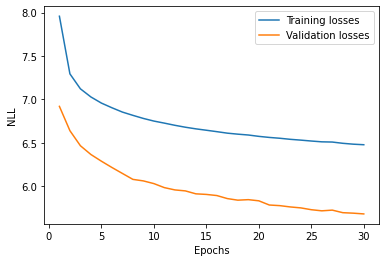

In [16]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [17]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | the the the the the the the the the the
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | States States States States States States States States States States
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | and and and and and and and and and and
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | , , , , , , , , , ,
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | , , , , , , , , , ,
Input | Output #6: <unk> , $ 96 million USD ) . Damage was heaviest 

In [18]:
torch.cuda.empty_cache()